# Bone Fracture Binary Classification using Pretrained ResNet18

In this project, we aim to utilize a pretrained `ResNet18` model in PyTorch to classify bone fracture images as either fractured or not fractured.

# 1. Importing Necessary Libraries
In this section, we import the essential libraries for data processing, model building, and evaluation. 
The libraries include:
- `os`, `numpy`, and `pandas`: for file handling and data manipulation.
- `torch`, `torchvision`: for building and training neural networks.
- `sklearn`: for model evaluation metrics.
- `PIL`: for image handling.

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from PIL import ImageFile
from PIL import Image

## 2. Setup Data Directories

Define the paths for the training, validation, and test datasets.

In [24]:
train_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\train"
val_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\val"
test_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\test"

In [25]:
# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

## 3. Data Preprocessing and Augmentation

We apply data transformations to the images, including resizing, normalization, and data augmentation for the training set.

In [26]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

## 4. Loading the Datasets

We load the training, validation, and test datasets using PyTorch's `ImageFolder` and apply the transformations.

In [27]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms['val'])

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
len(train_dataset)

9246

In [29]:
len(val_dataset)

829

In [30]:
len(test_dataset)

506

In [31]:
classes = os.listdir(train_dir)
len(classes)

2

In [32]:
classes

['fractured', 'not fractured']

## 5. Model Setup

We load a pretrained ResNet18 model, modify the final layer for binary classification, and move the model to the appropriate device (CPU or GPU).

In [33]:
# Set the device to GPU ('cuda') if available, otherwise default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# Initialize a pretrained ResNet18 model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze the pretrained layers

# Modify the final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1),
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

model = model.to(device)

c:\Users\daans\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\daans\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 6. Define Loss Function, Optimizer, and Scheduler

We define the binary cross-entropy loss, Adam optimizer, and a learning rate scheduler for training.

In [35]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## 7. Early Stopping Class

We define an `EarlyStopping` class to halt the training when the validation loss stops improving, preventing overfitting.


In [36]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

## 8. Training the Model with Early Stopping and Scheduler

We define the training loop where the model is trained with early stopping and learning rate scheduling.

In [ ]:
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=3):
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images)
                loss = criterion(outputs.view(-1), labels)
                val_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {running_loss / len(train_loader):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}")

        # Check early stopping conditions
        early_stopping(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

In [38]:
train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=3)

c:\Users\daans\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 0.4995, Val Loss: 0.4715
Epoch [2/10], Train Loss: 0.3859, Val Loss: 0.4525
Epoch [3/10], Train Loss: 0.3347, Val Loss: 0.4034
Epoch [4/10], Train Loss: 0.2986, Val Loss: 0.3723
Epoch [5/10], Train Loss: 0.2572, Val Loss: 0.3535
Epoch [6/10], Train Loss: 0.2251, Val Loss: 0.3491
Epoch [7/10], Train Loss: 0.2122, Val Loss: 0.3357
Epoch [8/10], Train Loss: 0.2036, Val Loss: 0.3343
Epoch [9/10], Train Loss: 0.2057, Val Loss: 0.3464
Epoch [10/10], Train Loss: 0.1990, Val Loss: 0.3299


## 9. Model Evaluation

We evaluate the model's accuracy on the test set and print detailed metrics using `classification_report`.

In [39]:
def evaluate_model_accuracy(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)  # Forward pass
            preds = (outputs.view(-1) > 0.5).float()  # Convert probabilities to binary predictions

            correct += (preds == labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Count total samples

    accuracy = correct / total  # Calculate accuracy
    print(f'Accuracy of the model on the test set: {accuracy * 100:.2f}%')
    return accuracy


In [40]:
# Evaluate the model
test_accuracy = evaluate_model_accuracy(model, test_loader)

Accuracy of the model on the test set: 86.76%


In [41]:
from sklearn.metrics import classification_report

def evaluate_model_metrics(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (outputs.view(-1) > 0.5).float()  # Convert probabilities to binary predictions

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report for detailed metrics
    print(classification_report(all_labels, all_preds, target_names=classes))

# Evaluate the model metrics
evaluate_model_metrics(model, test_loader)

               precision    recall  f1-score   support

    fractured       0.86      0.86      0.86       238
not fractured       0.87      0.88      0.88       268

     accuracy                           0.87       506
    macro avg       0.87      0.87      0.87       506
 weighted avg       0.87      0.87      0.87       506



## 10. Save the Model

Once training is complete, we save the model for future use.

In [46]:
model_save_path = "fracture_classification_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to fracture_classification_model.pth


## 11. Load the Model for Inference

To make predictions, we load the saved model and set it to evaluation mode.


In [47]:
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

model = load_model(model, model_save_path)

C:\Users\daans\AppData\Local\Temp\ipykernel_7500\3625135976.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


## 12. Inference on New Images

We define functions to predict the fracture status for new images, either from a URL or local file, and visualize the results.

In [48]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    
    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()  # Sigmoid to get probability
        label = "Fractured" if prob > 0.5 else "Not Fractured"
    
    return label, prob

## 13. Visualize the Prediction

We display the image along with the predicted fracture status and probability.

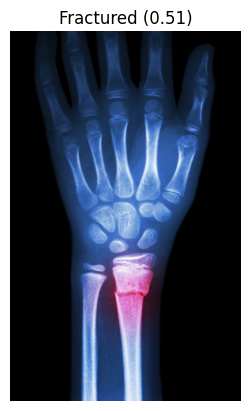

In [50]:
import requests
from io import BytesIO

# Function to open an image from a URL or a local file
def open_image(image_input):
    if image_input.startswith("http://") or image_input.startswith("https://"):
        # It's a URL
        response = requests.get(image_input)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        # It's a local file path
        image = Image.open(image_input).convert("RGB")
    return image

# Function to predict fracture status for a given image
def predict_image(image_input, model, transform):
    image = open_image(image_input)  # Open image from URL or local path
    image_transformed = transform(image).unsqueeze(0)  # Add batch dimension
    image_transformed = image_transformed.to(device)
    
    with torch.no_grad():
        output = model(image_transformed)
        prob = torch.sigmoid(output).item()  # Get the probability
        label = "Fractured" if prob > 0.5 else "Not Fractured"
    
    return label, prob

# Function to visualize the prediction
def visualize_prediction(image_input, model, transform):
    label, prob = predict_image(image_input, model, transform)
    image = open_image(image_input)  # Open image again for visualization
    
    plt.imshow(image)
    plt.title(f"{label} ({prob:.2f})")
    plt.axis("off")
    plt.show()

# Example usage
# example_image_input = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\test\fractured\001.png"  # local path

example_image_input = "https://healthcare.utah.edu/sites/g/files/zrelqx136/files/migrate_images/0_wny3n8ot.jpg"  # URL

visualize_prediction(example_image_input, model, transform)
